## 暂退法


![png](img\Snipaste_2022-04-05_21-18-41.png)

以p的概率将隐藏单元置为零时，结果可以看作是⼀个只包含原始神经元⼦集的⽹络。⽐如在上图中，删除了h2和h5，因此输出的计算不再依赖于h2或h5，并且它们各⾃的梯度在执⾏反向传播时也会消失。这样，输出层的计算不能过度依赖于h1···h5的任何⼀个元素。

在每层中具体的计算公式如下图：

![png](img\Snipaste_2022-04-05_22-17-02.png)

如果这个公式不能理解的话，可以看下面的代码输出。(上图的h和h`分别表示原来每层的值和暂退法之后的每层值)

## 暂退法的实现原理

In [1]:
import torch

def dropout_layer(X, dropout):
    '''
    assert表示断言
    如果dropout不在这个范围内的话就不执行函数
    '''
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    '''
    mask表示一个张量，这个张量中只有0和1
    如果随机生成的概率>dropout为1，反之，为0
    '''
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [2]:
#示例
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  0.,  0., 10., 12.,  0.],
        [ 0., 18.,  0., 22., 24.,  0., 28.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


## 暂退法在pytorch中的应用

In [3]:
#导入包并加载数据

%matplotlib inline
import torch
import numpy as np
import torchvision
from torch.utils import data
from torchvision import transforms

# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0到1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
root="../data", train=False, transform=trans, download=False)

#数据读取
batch_size = 256
def get_dataloader_workers(): 
#"""使⽤4个进程来读取数据"""
    return 4
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,
num_workers=get_dataloader_workers())

In [4]:
def accuracy(y_hat, y):
#"""计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
class Accumulator: 
#"""在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter): 
#"""计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


In [6]:
from torch import nn
dropout1, dropout2 = 0.2, 0.5
lr=0.1
net = nn.Sequential(nn.Flatten(),
nn.Linear(784, 256),
nn.ReLU(),
# 在第⼀个全连接层之后添加⼀个dropout层
nn.Dropout(dropout1),
nn.Linear(256, 256),
nn.ReLU(),
# 在第⼆个全连接层之后添加⼀个dropout层
nn.Dropout(dropout2),
nn.Linear(256, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);
sgd = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='mean')

0.8722666666666666
0.8451


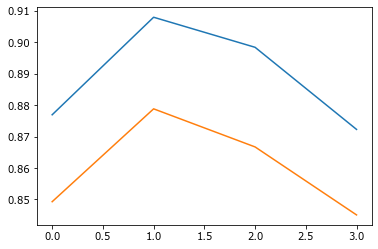

In [11]:
import matplotlib.pyplot as plt
import numpy as np
num_epochs=4
err_train=[]
err_test=[]
for epoch in range(num_epochs):
    for X,y in train_iter:
        y_hat=net(X)
        l=loss(y_hat,y)
        sgd.zero_grad()
        l.backward()
        sgd.step()
    err_train.append(evaluate_accuracy(net, train_iter))
    err_test.append(evaluate_accuracy(net, test_iter))
print(evaluate_accuracy(net, train_iter))
print(evaluate_accuracy(net, test_iter))
plt.plot(range(num_epochs),err_train)
plt.plot(range(num_epochs),err_test)